## Exercise 9.12

- [X] Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance). 
- [X] Use the model to generate some new faces (using the sample() method), and visualize them (if you used PCA, you will need to use its inverse_transform() method). 
- [X] Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

### Load data

In [1]:
from sklearn.datasets import fetch_olivetti_faces
fof = fetch_olivetti_faces()
data = fof["data"]
X = data
y = fof["target"]

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits = 1, test_size=40)
train_val_idx, test_idx = next(sss.split(X, y))
X_train_val = X[train_val_idx]
y_train_val = y[train_val_idx]
X_test = X[test_idx]
y_test = y[test_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=80)
train_idx, val_idx = next(sss.split(X_train_val, y_train_val))
X_train = X_train_val[train_idx]
y_train = y_train_val[train_idx]
X_val = X_train_val[val_idx]
y_val = y_train_val[val_idx]

### Reduce dimensionality of the data, preserving 99% of the information

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_train_red = pca.fit_transform(X_train)

### Train Gaussian Mixture

In [4]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=40)
y_pred = gm.fit_predict(X_train_red)

### Generate new faces and visualize them

In [5]:
number_faces = 10
new_faces_red, y_new_faces = gm.sample(n_samples=number_faces)
new_faces = pca.inverse_transform(new_faces_red)

In [6]:
from numpy import random
import matplotlib.pyplot as plt

def see_faces(img_dataset, num_faces=3):
  # Reshape 4096 image to 64x64 data
  imgs_idx = random.randint(len(img_dataset), size=num_faces)
  imgs = [img.reshape(64,64) for img in img_dataset[imgs_idx]]

  # Plot image
  import matplotlib
  fig, axs = plt.subplots(1, num_faces, figsize=(9, num_faces), sharey=True)
  for img, i in zip(imgs, range(0,num_faces)):
    axs[i].imshow(img, cmap='Greys_r', interpolation="nearest")
    axs[i].axis("off")

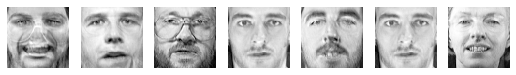

In [7]:
see_faces(new_faces, 7)

### Modify data inversing colours and looking for anomalies

In [8]:
# To invert colors, assuming every information is between 0 and 1, we'll manually
# write a function that subtracts 1 and get the absolute value left.
from numpy import copy

def invert_colors(image_data):
  new_data = copy(image_data)
  for image_idx, _ in enumerate(new_data):
    for pixel_idx, _ in enumerate(new_data[image_idx]):
      new_data[image_idx][pixel_idx] = abs(new_data[image_idx][pixel_idx]-1)
  return new_data

X_train_rev = invert_colors(X_train)

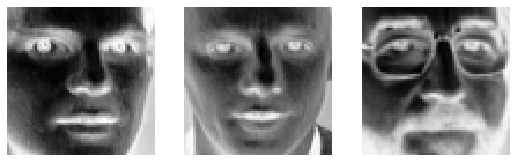

In [9]:
see_faces(X_train_rev)

In [10]:
# Transform the inverted images with PCA
X_train_rev_red = pca.transform(X_train_rev)

In [11]:
# Check GaussianMixture score for the inverted samples
gm.score_samples(X_train_rev_red[:10])

array([-67333916.01117595, -59856442.79959366, -50082084.95039891,
       -86220378.7646427 , -92872855.47270639, -76114190.57425839,
       -60345945.93825288, -65495716.89386596, -62205467.88159367,
       -46858608.51321379])

In [12]:
# For comparison, check the GaussianMixture score for the standard data
gm.score_samples(X_train_red[:10])

array([1155.25440881, 1110.814732  , 1141.20235742, 1097.26907713,
       1163.5739522 , 1141.36197838, 1140.04275305, 1116.67660036,
       1119.48727606, 1139.56974193])

Even with a light PCA reduction, the gaussian model recognize the inverted images having terrible scores, which means the model considered these images highly unlikely to be correlated with the "standard" images it was passed with the original dataset.

## Exercise 9.13

Some dimensionality reduction techniques can also be used for anomaly detection. For example, 
- [X] Take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. 
- [X] Then compute the reconstruction error for each image. 
- [X] Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.

### Reduce data

In [13]:
pca = PCA(n_components=0.99)
X_train_red = pca.fit_transform(X_train)

### Check reconstruction error

In [14]:
from numpy import mean
def reconstruction_error(pca, X):
  X_red = pca.transform(X)
  X_rec = pca.inverse_transform(X_red)
  return mean((X_rec-X)**2)

std_rec_err = reconstruction_error(pca,X_train)
std_rec_err

0.00018637152

In [15]:
inv_rec_err = reconstruction_error(pca,X_train_rev)
inv_rec_err

0.0020642444

In [16]:
print("The reconstruction error of the inverted (distorted) data is {:.2f}% greater than that of the standard data".format(((inv_rec_err/std_rec_err)-1)*100))

The reconstruction error of the inverted (distorted) data is 1007.60% greater than that of the standard data


Let's take a visual look on how bad it is. Let's take the inverted data (images with colors inverted) and reduce the dimensionality. Then we will recover the data using the same model, and inverse the colors once again to get the "original" data.

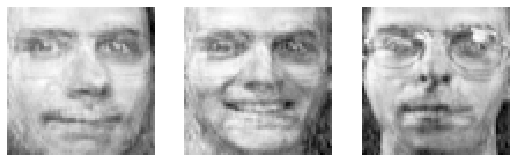

In [17]:
X_train_rev_red = pca.transform(X_train_rev)
X_train_rev_red_rec = pca.inverse_transform(X_train_rev_red)
X_train_rev_red_rec_rev = invert_colors(X_train_rev_red_rec)
see_faces(X_train_rev_red_rec_rev)

Yep, that's ugly and creepy.